# Stochastic Personal Finance Forecasting Simulator 
<b>Author:</b> Tyler Bikaun<br>
<b>Last Modified:</b> 14.03.2020

><b>Purpose:</b> Develop a user simulator based on object oriented design principles for use in stochastic personal financial forecasting.

<b>Modules Included</b>
<ol>
    <li>Asset Value</li>
    <li>Superannuation</li>
    <li>Tax</li>
    <li>Savings</li>
    <li>Expenses</li>
    <li>Income</li>
    <li>Loan</li>
    <li>Profile</li>
    <li>Simulation</li>
</ol>

><b>Inheritance:</b> 1:Asset Value to 7:Loan -> 8:Profile -> 9:Simulation

### Notebook set-up and importation of libraries

In [8]:
import datetime
from dateutil.relativedelta import relativedelta
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Initialisation of Classes

><b>Simulation:</b> The simulation class is used for simulating user lifetimes for stochastic modeling and analysis.

><b>Asset Value:</b> The AssetValue class is used for approximating user asset value and wealth. This is initially used for modeling real estate property value.

In [9]:
class AssetValue():
    """
    Model for approximating asset value and wealth.
    Initially used for property value
    """
    
    def __init__(self, assetReturnRate):
        self.assetReturnRate = assetReturnRate / 12
        
    def getAssetValue(self, assetPrincipal, compoundPeriod):
        # calculates asset value on a periodic compounding per month
        assetValue = assetPrincipal * (1 + self.assetReturnRate)**compoundPeriod
        return assetValue

><b>Superunnuation:</b> The Superunnuation class is used for capturing superannuation acquisition over time. Factors that are integrated into this class include: 1. super contributions (monthly freq), 2. initial balance, 3. rate of return, 4. employer contribution rate, 5. fees (administration and investment), 6. insurance premiums, and 7. indireect costs that aren't captured within these buckets.

In [10]:
class Superannuation():
    """
    Note: Assumes superannuation is run via an institution and is not self managed.
    
    """
    
    def __init__(self, contribRate):
        self.superContrib = 0
        self.superInitialBal = 1000   # initial super balance
        self.superReturnRate = 0.06 / 12
        
        self.contribRate = contribRate   # Employer contribution rate
        
        # Cumulative Sum of Super Balance and Value
        self.superBalCumSum = 0
        self.superValCumSum = 0
        
    def superFees(self, phase):
        if phase == 1:
            # phase 1 - before retirement
            self.contribFee = 1/12
        if phase == 2:
            # phase 2 - retirement
            self.contribFee = 0
        self.adminFee = 100
        self.investmentFee = 1/12
        self.insurancePrem = 1/12
        self.indirectCosts = 0.2/12
        self.superFeesTotal = 0
        
        self.superFeesTotal = self.adminFee + self.investmentFee * self.superContrib + \
                            self.contribFee * self.superContrib + self.insurancePrem * self.superContrib + \
                            self.indirectCosts * self.superContrib
        print(f'Super Fees: ${self.superFeesTotal:0.2f}')
        
    def superValue(self, phase):
        
        if self.superBalCumSum == 0:
            print('adding initial value to superVal')
            self.superValCumSum += self.superContrib + self.superInitialBal
        elif phase == 1:
#             print(f'{self.superValCumSum}-{self.superContrib}-{self.superFeesTotal}-{1 + self.superReturnRate}')
            
            self.superValCumSum = (self.superValCumSum + self.superContrib - self.superFeesTotal) * (1 + self.superReturnRate)
        elif phase == 2:
            self.superValCumSum = (self.superValCumSum - self.drawdownAmt - self.superFeesTotal) * (1 + self.superReturnRate)
        
        print(f'Super Value: ${self.superValCumSum:0.2f}')
        
        
    def superBalance(self):
        
        if self.superBalCumSum == 0:
            print('adding initial value to superBal')
            self.superBalCumSum += self.superContrib + self.superInitialBal
        else:
            self.superBalCumSum += self.superContrib - self.superFeesTotal
        
        print(f'Super Balance: ${self.superBalCumSum:0.2f}')
        
    def superContribution(self, phase, income):
        # Monthly income...
        self.superContrib = self.contribRate * income
        print(f'Super Contribution: ${self.superContrib:0.2f}')
        
        self.superFees(phase)
        self.superValue(phase)
        self.superBalance()
        
        
    def superDrawDown(self):
        # Drawdown once retirement starts and contributions cease
        retirementIncome = 25000
        self.drawdownAmt = retirementIncome / 12
        
        self.superContribution(2, 0)   # no income within phase 2
        
        

><b>Tax:</b> The Tax class is used to calculate payable tax on taxable income in accordance with tax rates set by the Australian Tax Office (ATO).

In [11]:
class Tax():
    """
    Model for taxing income.
    Calculates tax on gross annual income.
    Note: Tax rates are current as of 2019-2020 and sourced from the ATO.
    """
    
    def __init__(self):
        self.tax_table_income = {1: [0, 18200],
                    2: [18201, 37000],
                    3: [37001, 90000],
                    4: [90001, 180000],
                    5: [180001, 1000000000]}   # ridiculous upper limit

        self.tax_table_paymt = {1: [0, 0],
                        2: [0.19, 0],
                        3: [0.325, 3572],
                        4: [0.37, 20797],
                        5: [0.45, 54097]}
    
    def getTaxAmount(self, income):
        
        income = income * 12 # input is per month...
        
        for key, value in self.tax_table_income.items():
            if value[0] <= income <= value[1]:
                tax_to_pay = self.tax_table_paymt[key][1] + self.tax_table_paymt[key][0] * \
                (income - self.tax_table_income[key][0])
                
        monthlyIncomeTax = tax_to_pay / 12
        
        return monthlyIncomeTax

><b>Savings:</b> The Savings class is used for capturing user savings based on proportions saved which vary over time. Savings also work as a buffer for rare events that cannot be directly covered by income.

In [12]:
class Savings():
    """
    Model for savings.
    """
    
    def __init__(self, proportionSaved):
        self.proportionSaved = proportionSaved
        
        
        # data capture
        self.dataHistory = []
        self.savingHistory = []
        
    def getSavedAmount(self, remainingIncome):
        """
        Gets amount saved from remainingIncome
        """
        if remainingIncome > 0:
            return remainingIncome*self.proportionSaved
        else: 
            return 0
        
    # Data Capture Functions
    def getSavingHistory(self, date, savingInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.savingHistory.append(savingInfo)

><b>Expenses:</b> The Expenses class is used to capture expenses relating to life in general. This is currently modelled as being stochastic within certain limits based on living costs.

In [13]:
class Expenses():
    """
    Model for general expenses.
    """
    
    def __init__(self, expenses):
        # Everything is on a monthly basis in the model...
        self.expenses = expenses
        
    def increaseExpenseRandomly(self, phase):
        """
        Increase principal by a random amount to simulate expense tranfers.
        This can only occur if the loan is still active. 
        TODO: integrate expenses and ability for profile to override 'active' status to ressurect their paid off loans...
        """

        expensesTemp = 0
        if (0.5 < np.random.uniform(0,1)):
            if phase == 2:
                increaseAmt = np.random.uniform(0.8, 1.2)*(self.expenses / 2)
            else:
                increaseAmt = np.random.uniform(0.8, 1.2)*(self.expenses)
            
            print(f'Expense balance: ${increaseAmt:0.2f}')
            return increaseAmt
        else:
            print('Expenses remain unchanged at:', self.expenses)
            if phase == 2:
                return self.expenses / 2
            else:
                return self.expenses

><b>Income:</b> The Income class is used for generating cash flow for users. Income is determined by three means (as defined by various financial institutions): 1. earned, 2. passive, and 3. portfolio.

In [14]:
class Income():
    """
    Model for income (earned, passive, portfolio).
    """
    
    def __init__(self, income):
        # Everything is on a monthly basis in the model...
        self.income = income
        self.remainingIncome = self.income    # init
        self.dateHistory = []
        self.incomeHistory = []

        
    def incomeAfterCosts(self, loanPaymentSum):
        """
        Aggregated Monthly.
        """
        costs = loanPaymentSum
        self.remainingIncome = self.income - costs
        
    def getIncomeHistory(self, date, incomeInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.incomeHistory.append(incomeInfo)

><b>Loan:</b> The Loan class captures loans and their attributes. Attributes include: 1. principal, 2. interest rate, 3. annual payments, 4. duration, and 5. startdate. Loans are an important factor in user simulation as they can be stackable (have more than one at a time).

In [15]:
class Loan():
    """
    Model for user profile loans.
    """
    
    def __init__(self, loanID, principal, interestRate, annualPayments, duration, startDate):
        self.principal = principal
        self.interestRate = interestRate
        self.annualPayments = annualPayments
        self.duration = duration
        self.startDate = datetime.datetime.strptime(startDate, '%d-%m-%Y').date()
        self.loanID = loanID
        self.period = 1
        self.endDate = (self.startDate + relativedelta(years=self.duration))
        self.beginBalance = self.principal
        self.endBalance = self.principal
        self.loanPaidOff = False
        self.loanPaidOffDate = 'Not paid off - Active'
        self.loanActive = False
        
        # First loan payment amount
        self.loanPayment = -round(np.pmt(self.interestRate/self.annualPayments, self.duration*self.annualPayments, self.principal), 2)      
    
        # For data capture
        self.dateHistory = []
        self.loanHistory = []
    
    def initDesc(self):
        return f'''Loan {self.loanID} has principal of ${self.principal} over duration {self.duration} years with expected finish date of {self.endDate} - remaining balance: ${self.endBalance}'''
    
    # Main Functions
    def makePayment(self):
        """
        Make a payment against the principal.
        """
        self.loanActive = True
        self.interest = round(((self.interestRate/self.annualPayments) * self.beginBalance), 2)
        self.loanPayment = min(self.loanPayment, self.beginBalance + self.interest)
        self.endBalance = self.beginBalance - (self.loanPayment - self.interest)
        self.period += 1
        self.beginBalance = self.endBalance
        
    def paymentSummary(self):
        try:
            print(f'Period: {self.period} BeginBalance: {self.beginBalance:0.2f} Principal: {self.principal:0.2f} Interest: {self.interest:0.2f} Payment: {self.loanPayment:0.2f}')
        except:
            print('Not enough information. Loan has likely not become active.')

    def loanFinished(self, date):
        """
        Used when a loan is finished.
        """
        #TODO: Add date for when loan finishes... as this may not be constant...
        self.loanPaidOff = True
        self.loanActive = False
        self.loanPaidOffDate = date
    
    # Misc Functions
    def increasePrincipal(self, increaseAmt):
        """
        Increase the amount of loan principal via month begin balance.
        """
        self.beginBalance += increaseAmt
        
    def increasePrincipalRandomly(self):
        """
        Increase principal by a random amount to simulate expense tranfers.
        This can only occur if the loan is still active. 
        TODO: integrate expenses and ability for profile to override 'active' status to ressurect their paid off loans...
        """
        if (0.99 < np.random.uniform(0,1)) and self.loanActive:
            if self.loanPaidOff == False:
                increaseAmt = np.random.randint(0,10)*1000
                self.beginBalance += increaseAmt
                print(f'Increased {self.loanID} balance by ${increaseAmt}')       
        
    # Data Capture Functions
    def getLoanHistory(self, date, loanInfo):
        """
        Used to capture temporal data for plotting and analysis.
        """
        self.dateHistory.append(date)
        self.loanHistory.append(loanInfo)

><b>Profile:</b> The Profile class is for generating user profiles. A user profile can have the previously defined classes attributed to it e.g. income, expenses, savings, tax, superannuations, and asset value. A user profile is simulated over a lifetime, the lifetime is split into two phases 1. working, and 2. retirement. In the first phase, working, the user typically would take out loans, have income, commit to superannuation, etc. In the second phase, retirement, the income streams change, superannuation starts to be drawn down, etc. Parameters of the user profile include 1. name, 2. age, 3. expected retirement age (will be an output rather than an input in the future), and 4. expected age of death (assumed from health statistics based on gender; could be extended based on other salient factors).

In [22]:
class Profile(Income, Expenses, Savings, Tax, Superannuation, AssetValue):
    """
    Profile for user. Contains their general information and meta data for financial modeling.
    """
    
    # Initializer / Instance Attributes
    def __init__(self, name, age, retireAge, deadAge, incomePA, expensesPM, proportionSaved):
        self.name = name
        self.age = age
        self.retireAge = retireAge
        self.deadAge = deadAge
        # Loans
        self.hasLoan = False
        self.loanDict = {}
        self.noLoans = 0
        self.loanPaymentSum = 0
        # Income
        self.hasIncome = False
        self.income = incomePA / 12
        self.hasIncome = True
        # Expenses
        self.expenses = expensesPM    # Expenses per month
        # Savings
        self.proportionSaved = proportionSaved

        
        # Inherit Loan init.. by inheriting this class, we can access it's attributes and methods...
        Income.__init__(self, self.income)  # pass attribute to class
        
        # Init Expenses
        Expenses.__init__(self, self.expenses)
        
        
        # Init Savings
        Savings.__init__(self, self.proportionSaved)
        
        # Init Tax
        Tax.__init__(self)
        
        # init super
        Superannuation.__init__(self, 0.095)
        
        # init asset value
        AssetValue.__init__(self, 0.06)
        
        
    # Profile
    def ageStep(self, year):
        """
        Used to age the users profile and step through time.
        """
        self.age += year
    
    def summary(self):
        print(f'{self.name} is {self.age} years old and has an income of ${self.income:0.2f} per month.\n')
    
    # Loan
    def getLoan(self, principal, interestRate, annualPayments, duration, startDate):
        """
        Allocates a loan to the profile.
        """
        self.hasLoan = True
        self.noLoans += 1
        print(f'Number of loans: {self.noLoans}')
        loanID = str(self.noLoans)
        self.loanDict[loanID] = Loan(loanID, principal, interestRate, annualPayments, duration, startDate)
        
    def removeLoan(self, loanID):
        """
        Removes a loan from the profile. TODO: update to remove once paid off.
        """
        try:
            del self.loanDict[loanID]
        except:
            print('Loan doesnt exist')
            
    def loanDesc(self):
        """
        Summary of active loans.
        """
        self.currentLoans = len(self.loanDict)
        try:
            return f'Current active loans for {self.name}: {self.currentLoans}'
        except:
            return f'{self.name} has no loan'
        
    def loanInfo(self):
        """
        Detailed description of loan dict. For debugging purposes.
        """
        for loanID, loanDetails in self.loanDict.items():
            print(f'{loanDetails.initDesc()}')

## Running Basic User Simulation

### Initialise user profile with basic information

In [49]:
def init_profile():
    """
    Profile initialisation.
    """
    # Initialise Profile class
    myProfile = Profile(name='tyler',age=26,retireAge=65,deadAge=80,incomePA=52000,expensesPM=2000,proportionSaved=0.25)

    # Initialise loans and attribute them to the user profile
    # Loan 1 - mortgage
    myProfile.getLoan(principal=300000,interestRate=0.04,annualPayments=12,duration=25,startDate='1-1-2021')
    # Loan 2 - car
    myProfile.getLoan(principal=50000,interestRate=0.12,annualPayments=12,duration=5,startDate='01-01-2025')
    # Loan 3 - car 2
    myProfile.getLoan(principal=7000,interestRate=0.08,annualPayments=12,duration=10,startDate='01-06-2027')
    
    # Output information pertaining to to user profile summary and loan descriptions/information
    myProfile.summary()
    myProfile.loanDesc()
    myProfile.loanInfo()
    
    return myProfile

In [50]:
myProfile = init_profile()

Number of loans: 1
Number of loans: 2
Number of loans: 3
tyler is 26 years old and has an income of $4333.33 per month.

Loan 1 has principal of $300000 over duration 25 years with expected finish date of 2046-01-01 - remaining balance: $300000
Loan 2 has principal of $50000 over duration 5 years with expected finish date of 2030-01-01 - remaining balance: $50000
Loan 3 has principal of $7000 over duration 10 years with expected finish date of 2037-06-01 - remaining balance: $7000


### Simulate User Profile - 1 Lifetime

#### Simulation Iterations
Note: Simulation outputs on a monthly frequency.

In [51]:
def simulate():
    # Duration of simulation (phase 1)
    dateStart = datetime.date(2020,1,1)
    dateStartTemp = dateStart
    
    
    # Iterate over life with month level grainularity
    print('\n----- ENTERING PHASE ONE -----\n')
    while myProfile.age < myProfile.retireAge:
        # Current datetime of step
        print(f'\n {dateStartTemp}')
        print(f'Monthly Income: ${myProfile.income:0.2f}')

        # Tax
        tax = myProfile.getTaxAmount(myProfile.income)
        print(f'Tax: ${tax:0.2f}')

        # Super
        myProfile.superContribution(1, myProfile.income)

        tempLoanCost = 0

        # Pay debts
        for loanID, loanInfo in myProfile.loanDict.items():
            if myProfile.loanDict[loanID].startDate <= dateStartTemp:

                # Random change of principal injection
                myProfile.loanDict[loanID].increasePrincipalRandomly()

                # If balance remains on loans - make payment
                if 0 < myProfile.loanDict[loanID].beginBalance:
                    # Raise payment against loan
                    myProfile.loanDict[loanID].makePayment()
                    myProfile.loanDict[loanID].paymentSummary()

                    # Capture loan history information for future use
                    myProfile.loanDict[loanID].getLoanHistory(dateStartTemp, myProfile.loanDict[loanID].beginBalance)

                    # Actuate attribute when loan is paid off.
                    if myProfile.loanDict[loanID].beginBalance == 0:
                        print(f'LOAN {loanID} PAID OFF!')
                        # Setting finished to True
                        myProfile.loanDict[loanID].loanFinished(dateStartTemp)

                    else:
                        # Capture loanPayment for totalcost agg
                        print(f'Loan {loanID} - Begin Balance: ${myProfile.loanDict[loanID].beginBalance:0.2f} Payment: {myProfile.loanDict[loanID].loanPayment:0.2f}')
                        tempLoanCost += myProfile.loanDict[loanID].loanPayment

                else:
                    # No principal - either loan hasnt begun or its finished
                    myProfile.loanDict[loanID].getLoanHistory(dateStartTemp, 0)

            else:
                # Too early - no loans are active
                myProfile.loanDict[loanID].getLoanHistory(dateStartTemp, 0)
                pass


        expenses =  myProfile.increaseExpenseRandomly(1)

        myProfile.incomeAfterCosts(tax + tempLoanCost + expenses)
        print(f'Income Remaining: ${myProfile.remainingIncome:0.2f}')
        myProfile.getIncomeHistory(dateStartTemp, myProfile.remainingIncome)

        savedAmt = myProfile.getSavedAmount(myProfile.remainingIncome)
        print(f'Amount saved this month: ${savedAmt:0.2f}')

        
        # asset value
#         myProfile.getAssetValue(myProfile, compoundPeriod)

        yield OrderedDict([('Date', dateStartTemp),
                          ('Income', myProfile.income),
                          ('Tax', myProfile.getTaxAmount(myProfile.income)),
                          ('SuperContrib', myProfile.superContrib),
                           ('SuperBalance', myProfile.superBalCumSum),
                           ('SuperValue', myProfile.superValCumSum),
                          ('LoanDebt', tempLoanCost),
                          ('Expenses', expenses),
                          ('RemainingIncome', myProfile.remainingIncome),
                          ('SavedAmt', savedAmt)])


        # Steps through time month-by-month
        dateStartTemp += relativedelta(months=1)

        # Adds year to age during simulation
        if dateStartTemp.month == 1 and (dateStartTemp.year - dateStart.year) > 0:
            #print(f'Year: {dateStartTemp.year - dateStart.year}')
            myProfile.ageStep(1)
            
    # Iterate over life with month level granularity
    print('\n----- ENTERING PHASE TWO -----\n')
    while myProfile.age < myProfile.deadAge:
        print(f'\n {dateStartTemp}')
        
        # Super drawdown
        myProfile.superDrawDown()
        
        expenses =  myProfile.increaseExpenseRandomly(2)
        
        yield OrderedDict([('Date', dateStartTemp),
                          ('Income', 0),
                          ('Tax', 0),
                          ('SuperContrib', 0),
                           ('SuperBalance', myProfile.superBalCumSum),
                           ('SuperValue', myProfile.superValCumSum),
                          ('LoanDebt', 0),
                          ('Expenses', expenses),
                          ('RemainingIncome', 0),
                          ('SavedAmt', 0)])
        
        
        
        dateStartTemp += relativedelta(months=1)
        # Adds year to age during simulation
        if dateStartTemp.month == 1 and (dateStartTemp.year - dateStart.year) > 0:
            print(f'Year: {dateStartTemp.year - dateStart.year}')
            myProfile.ageStep(1)

In [52]:
df = pd.DataFrame(simulate())


----- ENTERING PHASE ONE -----


 2020-01-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
adding initial value to superVal
Super Value: $1411.67
adding initial value to superBal
Super Balance: $1411.67
Expense balance: $2376.01
Income Remaining: $1253.44
Amount saved this month: $313.36

 2020-02-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $1621.62
Super Balance: $1613.56
Expenses remain unchanged at: 2000
Income Remaining: $1629.44
Amount saved this month: $407.36

 2020-03-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $1832.63
Super Balance: $1815.44
Expenses remain unchanged at: 2000
Income Remaining: $1629.44
Amount saved this month: $407.36

 2020-04-01
Monthly Income: $4333.33
Tax: $703.89
Super Contribution: $411.67
Super Fees: $209.78
Super Value: $2044.69
Super Balance: $2017.33
Expense balance: $1670.49
Income Remaining: $

In [55]:
df.head(100)

,Date,Income,Tax,SuperContrib,SuperBalance,SuperValue,LoanDebt,Expenses,RemainingIncome,SavedAmt
0,2020-01-01,4333.333333,703.889583,411.666667,1411.666667,1411.666667,0.00,2376.006074,1253.437676,313.359419
1,2020-02-01,4333.333333,703.889583,411.666667,1613.555556,1621.623333,0.00,2000.000000,1629.443750,407.360937
2,2020-03-01,4333.333333,703.889583,411.666667,1815.444444,1832.629783,0.00,2000.000000,1629.443750,407.360937
3,2020-04-01,4333.333333,703.889583,411.666667,2017.333333,2044.691266,0.00,1670.489392,1958.954358,489.738590
4,2020-05-01,4333.333333,703.889583,411.666667,2219.222222,2257.813055,0.00,2050.691700,1578.752050,394.688013
5,2020-06-01,4333.333333,703.889583,411.666667,2421.111111,2472.000454,0.00,1658.064427,1971.379323,492.844831
6,2020-07-01,4333.333333,703.889583,411.666667,2623.000000,2687.258789,0.00,2206.328242,1423.115508,355.778877
7,2020-08-01,4333.333333,703.889583,411.666667,2824.888889,2903.593417,0.00,2000.000000,1629.443750,407.360937
8,2020-09-01,4333.333333,703.889583,411.666667,3026.777778,3121.009717,0.00,2000.000000,1629.443750,407.360937
9,2020-10-01,4333.333333,703.889583,411.666667,3228.666667,3339.513099,0.00,2000.000000,1629.443750,407.360937


In [54]:
df.to_csv('qa.csv')

## Lifetime Visualisations

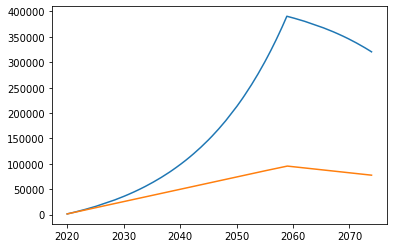

In [36]:
plt.plot(df['Date'], df['SuperValue'])
plt.plot(df['Date'], df['SuperBalance'])
plt.show()

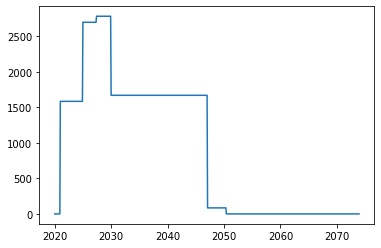

In [37]:
plt.plot(df['Date'], df['LoanDebt'])
plt.show()

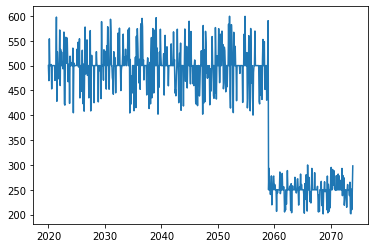

In [38]:
plt.plot(df['Date'], df['Expenses'])
plt.show()

In [39]:
myProfile.summary()

tyler is 80 years old and has an income of $4333.33 per month.



In [40]:
myProfile.loanInfo()

Loan 1 has principal of $300000 over duration 25 years with expected finish date of 2046-01-01 - remaining balance: $0.0
Loan 2 has principal of $50000 over duration 5 years with expected finish date of 2030-01-01 - remaining balance: $0.0
Loan 3 has principal of $7000 over duration 10 years with expected finish date of 2037-06-01 - remaining balance: $0.0


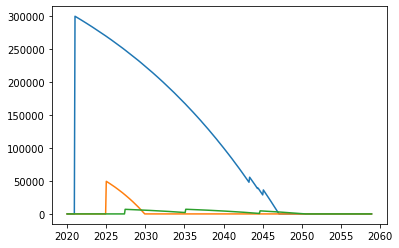

In [41]:
for loanID, _ in myProfile.loanDict.items():
    
    plt.plot(myProfile.loanDict[loanID].dateHistory, myProfile.loanDict[loanID].loanHistory)

In [42]:
myProfile.loanDict['2'].loanPaidOff

True

In [43]:
print('Loan 1')
print('Start Date:', myProfile.loanDict['1'].startDate)
print('Expected End Date:', myProfile.loanDict['1'].endDate)
print('Finish Date:', myProfile.loanDict['1'].loanPaidOffDate)

Loan 1
Start Date: 2021-01-01
Expected End Date: 2046-01-01
Finish Date: 2047-02-01


In [44]:
print('Loan 2')
print('Start Date:', myProfile.loanDict['2'].startDate)
print('Expected End Date:', myProfile.loanDict['2'].endDate)
print('Finish Date:', myProfile.loanDict['2'].loanPaidOffDate)

Loan 2
Start Date: 2025-01-01
Expected End Date: 2030-01-01
Finish Date: 2030-01-01


In [45]:
print('Loan 3')
print('Start Date:', myProfile.loanDict['3'].startDate)
print('Expected End Date:', myProfile.loanDict['3'].endDate)
print('Finish Date:', myProfile.loanDict['3'].loanPaidOffDate)

Loan 3
Start Date: 2027-06-01
Expected End Date: 2037-06-01
Finish Date: 2050-06-01


Text(0, 0.5, '$ Amount')

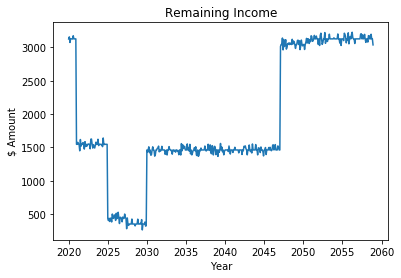

In [46]:
plt.plot(myProfile.dateHistory, myProfile.incomeHistory)
plt.title('Remaining Income')
plt.xlabel('Year')
plt.ylabel('$ Amount')